# Search in imperfect info games

Playing around with the theoretical experiment proposed on Noam Brown PhD thesis example on page 123.

In [10]:
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import seaborn as sns

# Helper functions

In [19]:
def _softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
    return e_x / e_x.sum()

In [2]:
import pandas as pd

def plot_average_convergence(p1_payouts, window_size=50):
    # Calculate the cumulative sum and the number of elements
    cumulative_sum = np.cumsum(p1_payouts)
    n = len(p1_payouts)

    # Calculate the moving average
    moving_average = cumulative_sum / np.arange(1, n+1)

    # Convert the moving average into a pandas series to compute the rolling standard deviation
    moving_average_series = pd.Series(moving_average)
    rolling_std = moving_average_series.rolling(window=window_size).std()

    # Create the plot for moving average
    plt.figure(figsize=(12, 6))
    plt.plot(moving_average[window_size:], label='Moving Average', color='b')
    
    # Plot the rolling standard deviation of the moving average
    plt.plot(rolling_std[window_size:], label=f'Std Dev of Moving Average (Window={window_size})', color='orange')

    # Mark the final value of the moving average and its standard deviation
    final_average = moving_average[-1]
    final_std = rolling_std.dropna().values[-1]  # last non-NaN value
    plt.axhline(y=final_average, color='r', linestyle='--', label=f'Final Average = {final_average:.2f}')
    plt.axhline(y=final_std, color='g', linestyle='--', label=f'Final Std Dev of Avg = {final_std:.4f}')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Convergence of the Average and Its Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
def plot_average_evolution(p1_payouts):
  # Calculate the cumulative sum and the number of elements
  cumulative_sum = np.cumsum(p1_payouts)
  n = len(p1_payouts)

  # Calculate the moving average
  moving_average = cumulative_sum / np.arange(1, n+1)

  # Calculate the final average
  final_average = cumulative_sum[-1] / n

  # Create the plot
  plt.figure(figsize=(12, 6))
  plt.plot(moving_average[20:], label='Moving Average')
  plt.axhline(y=final_average, color='r', linestyle='--', label=f'Final Average = {final_average:.2f}')
  plt.xlabel('Index')
  plt.ylabel('Average')
  plt.title('Evolution of Average')
  plt.legend()
  plt.grid(True)
  plt.show()

# Definition of strategy

In [5]:
@dataclass
class P1_Strategy:
    sell_prob_given_heads: float = 0.0
    # play_prob_given_heads: float = 0.0
    sell_prob_given_tails: float = 0.0
    # play_prob_given_tails: float = 0.0

@dataclass
class P2_Strategy:
    heads_prob: float = 0.0
    # tails_prob: float = 0.0

In [32]:
def simulate_game(
        p1_strategy:P1_Strategy,
        p2_strategy:P2_Strategy,
        reward_p1_sell_on_heads=0.5,
        reward_p1_sell_on_tails=-0.5,
    ):
    # flip coin
    c = 'tails' if random.random() < 0.5 else 'heads'
    # p1 observes coin flip result, and picks an action
    if c == 'tails':
        p1_action = 'sell' if random.random() < p1_strategy.sell_prob_given_tails else 'play'
    elif c == 'heads':
        p1_action = 'sell' if random.random() < p1_strategy.sell_prob_given_heads else 'play'
    # p2 doen't get to see the coin flip result
    # chooses his action independently
    p2_action = None
    if p1_action == 'play':
        p2_action = 'heads' if random.random() < p2_strategy.heads_prob else 'tails'
    
    # compute the game outcome for p1
    if c == 'heads':
        if p1_action == 'sell':
            reward_p1 = reward_p1_sell_on_heads
        elif p1_action == 'play':
            reward_p1 = -1 if p2_action == 'heads' else 1
    elif c == 'tails':
        if p1_action == 'sell':
            reward_p1 = reward_p1_sell_on_tails
        elif p1_action == 'play':
            reward_p1 = 1 if p2_action == 'heads' else -1
    # return all
    return (reward_p1, c, p1_action, p2_action)

## Correction tests

This should give $.75 as avg return

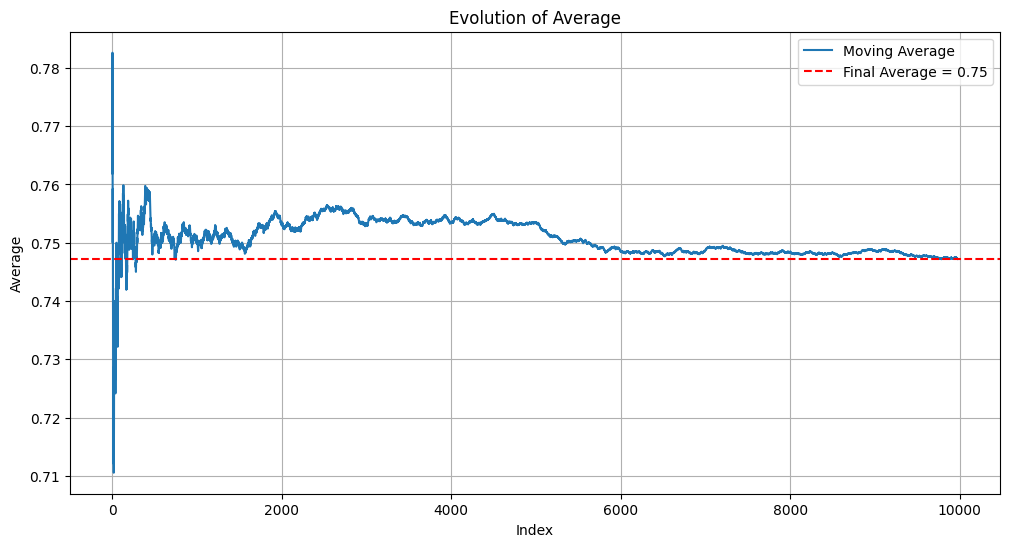

In [7]:
p1_payouts = [
    simulate_game(
        p1_strategy=P1_Strategy(
            sell_prob_given_heads=(1),
            sell_prob_given_tails=(0),
        ),
        p2_strategy=P2_Strategy(
            heads_prob=1,
        ),
    )[0]
    for _ in range(10_000)
]
plot_average_evolution(p1_payouts)

This should give $0.25 as avg return

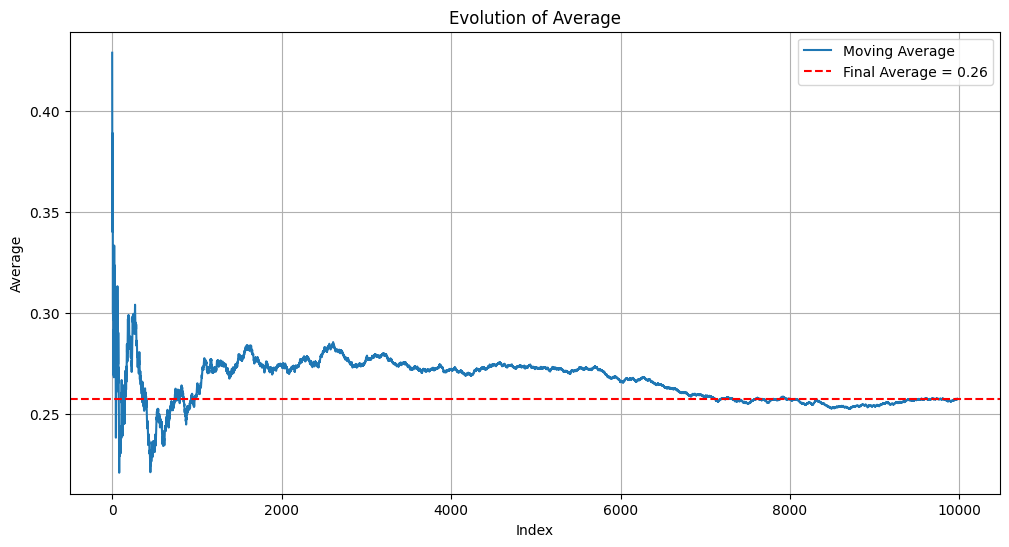

In [8]:
p1_payouts = [
    simulate_game(
        p1_strategy=P1_Strategy(
            sell_prob_given_heads=(0),
            sell_prob_given_tails=(1),
        ),
        p2_strategy=P2_Strategy(
            heads_prob=0,
        ),
    )[0]
    for _ in range(10_000)
]
plot_average_evolution(p1_payouts)

The best strategy for p2 & p1 which should result in $0 on expectation for both

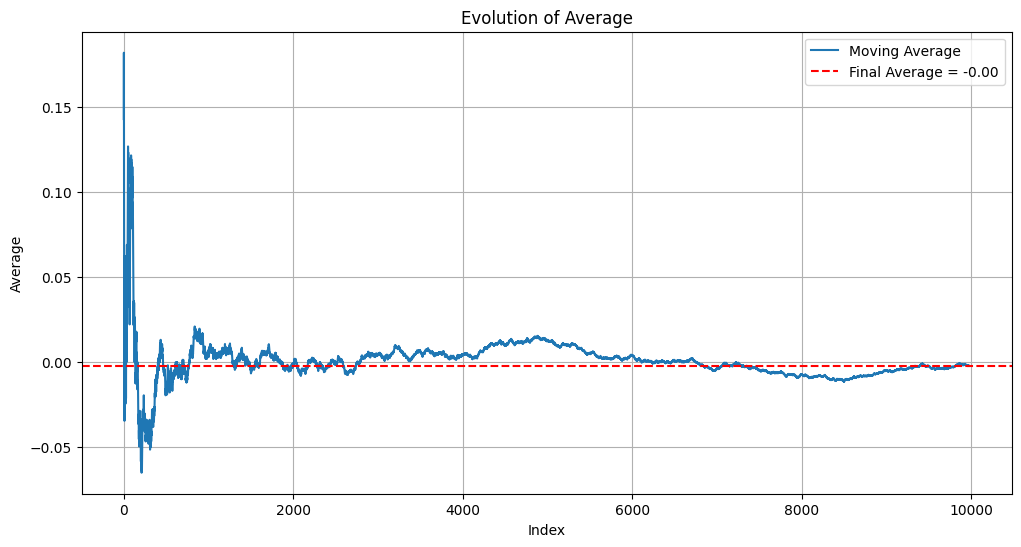

In [9]:
p1_payouts = [
    simulate_game(
        p1_strategy=P1_Strategy(
            sell_prob_given_heads=(0),
            sell_prob_given_tails=(0),
        ),
        p2_strategy=P2_Strategy(
            heads_prob=0.25,
        ),
    )[0]
    for _ in range(10_000)
]
plot_average_evolution(p1_payouts)

# Brute force exploitability and visualization

Of all possible combinations, does P2 wants to find a `p2_heads_prob` that:

- the matrix has on average, the lowest value?
- or minimize the maximum value of the matrix?

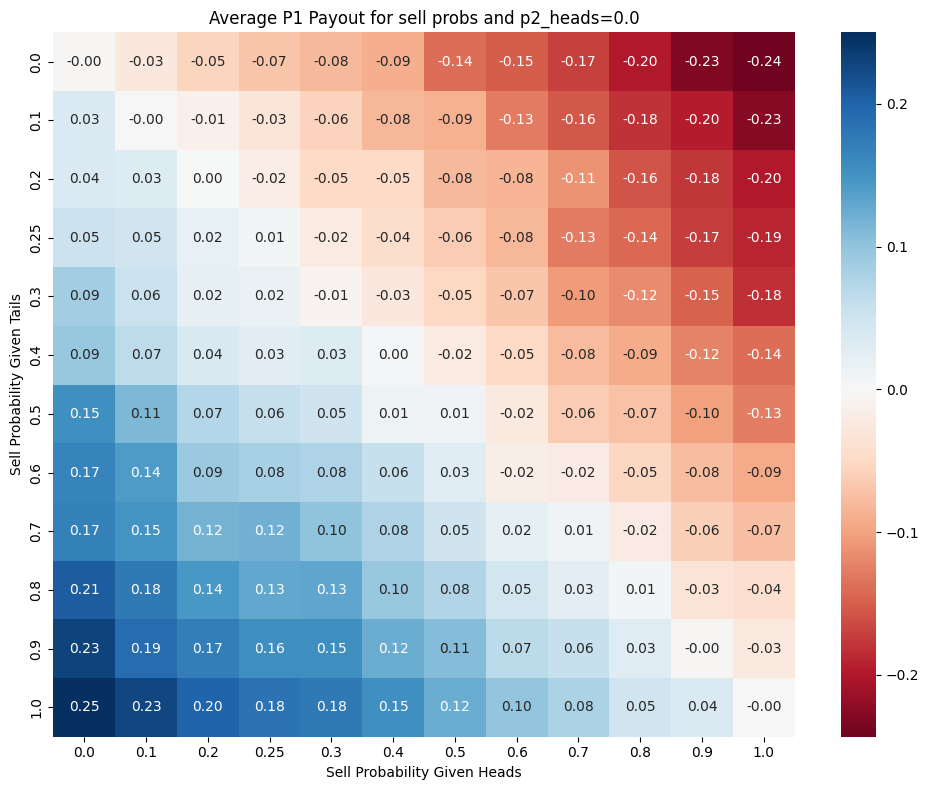

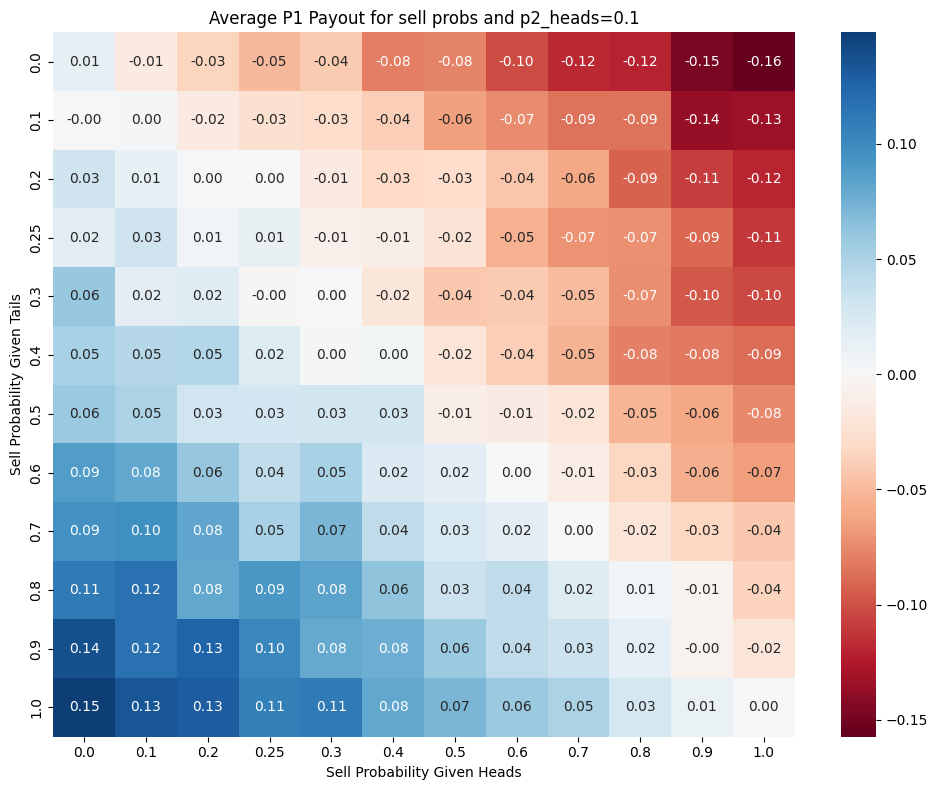

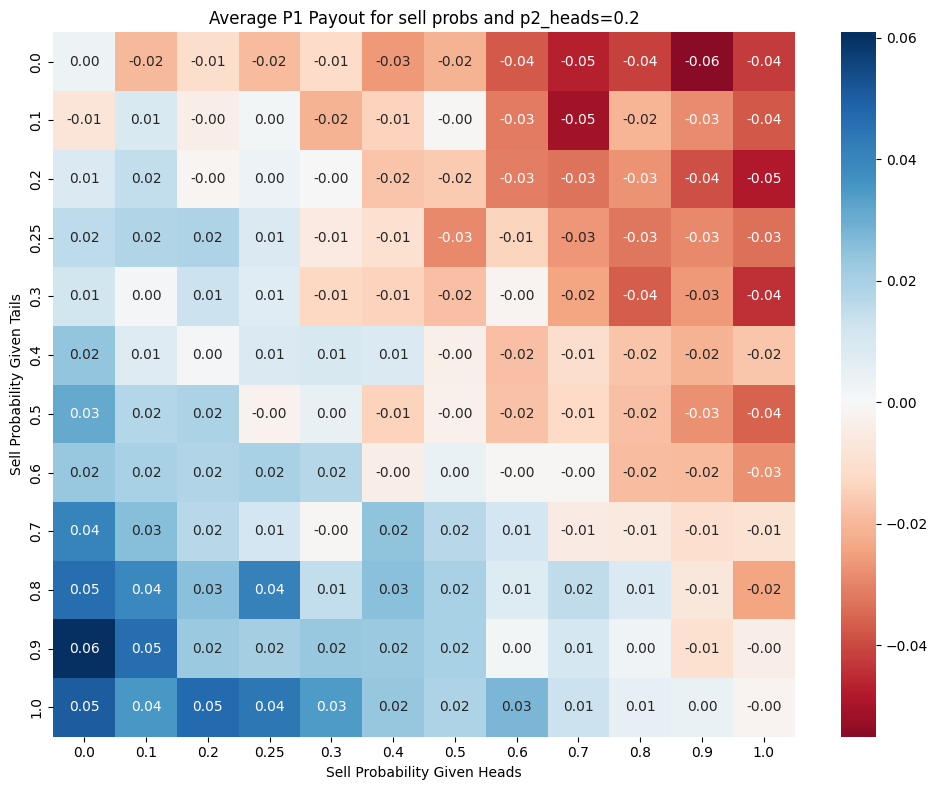

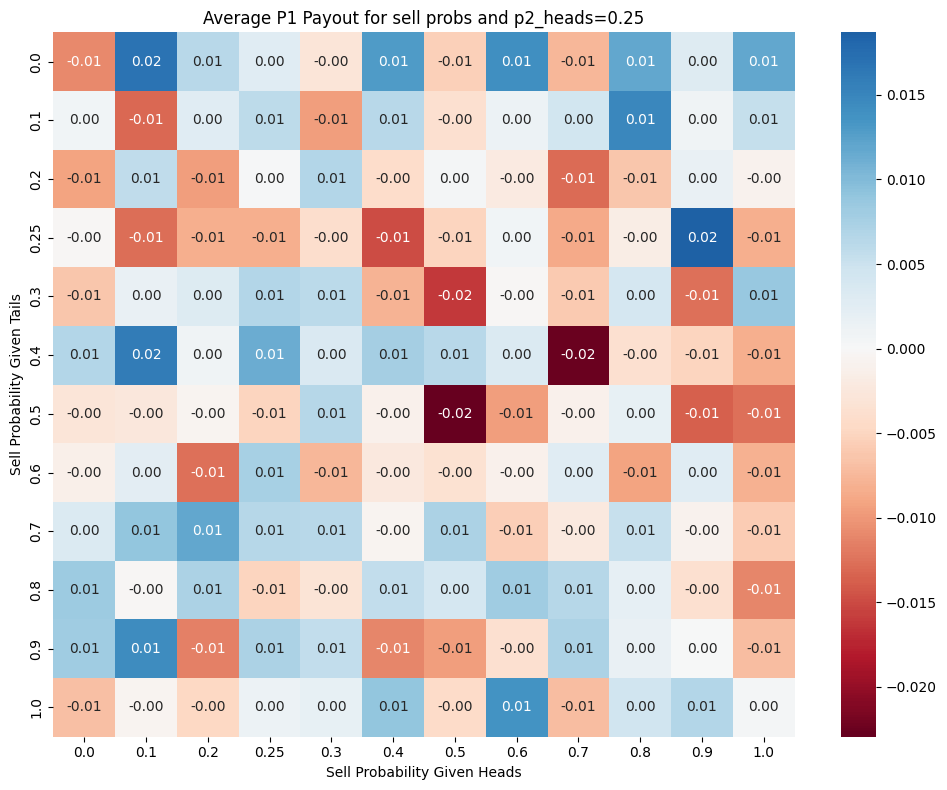

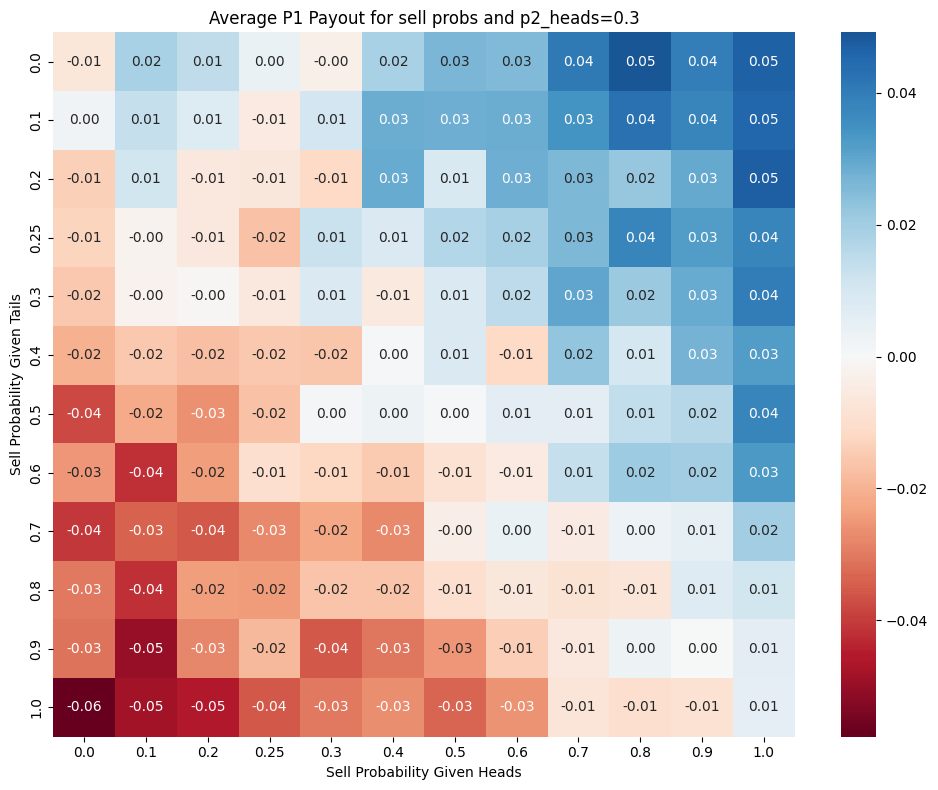

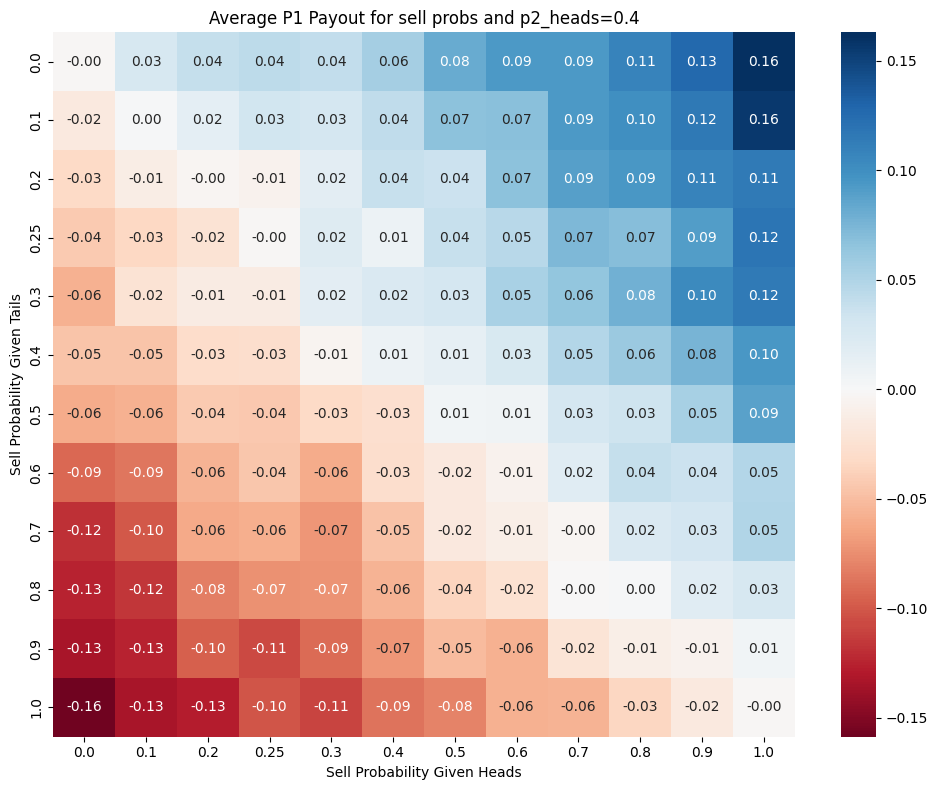

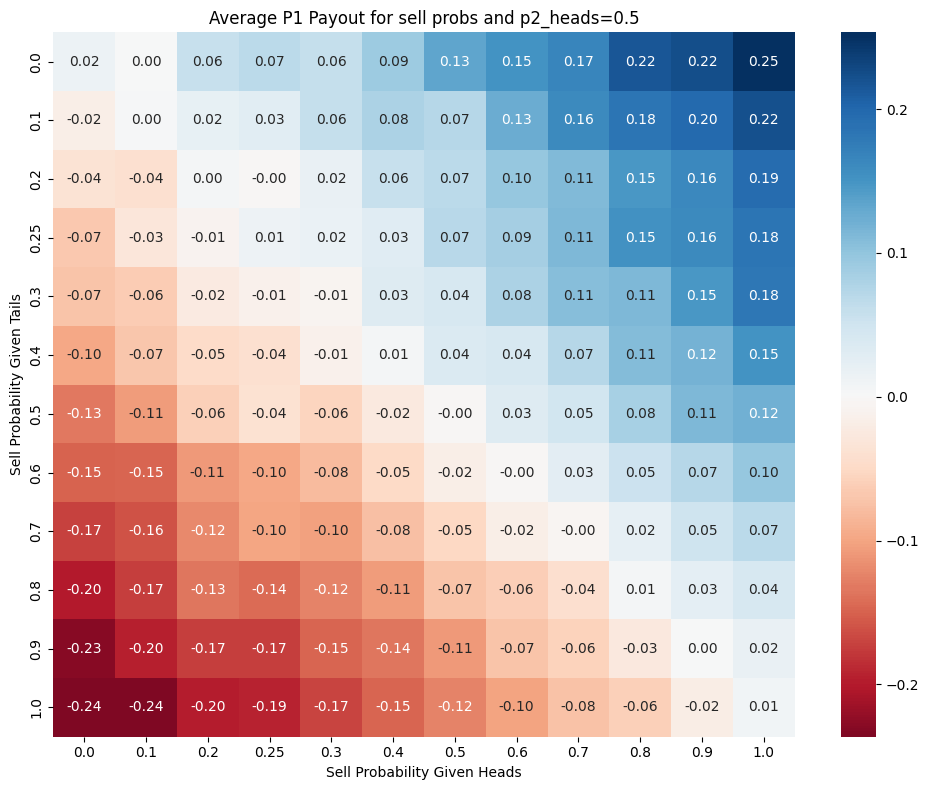

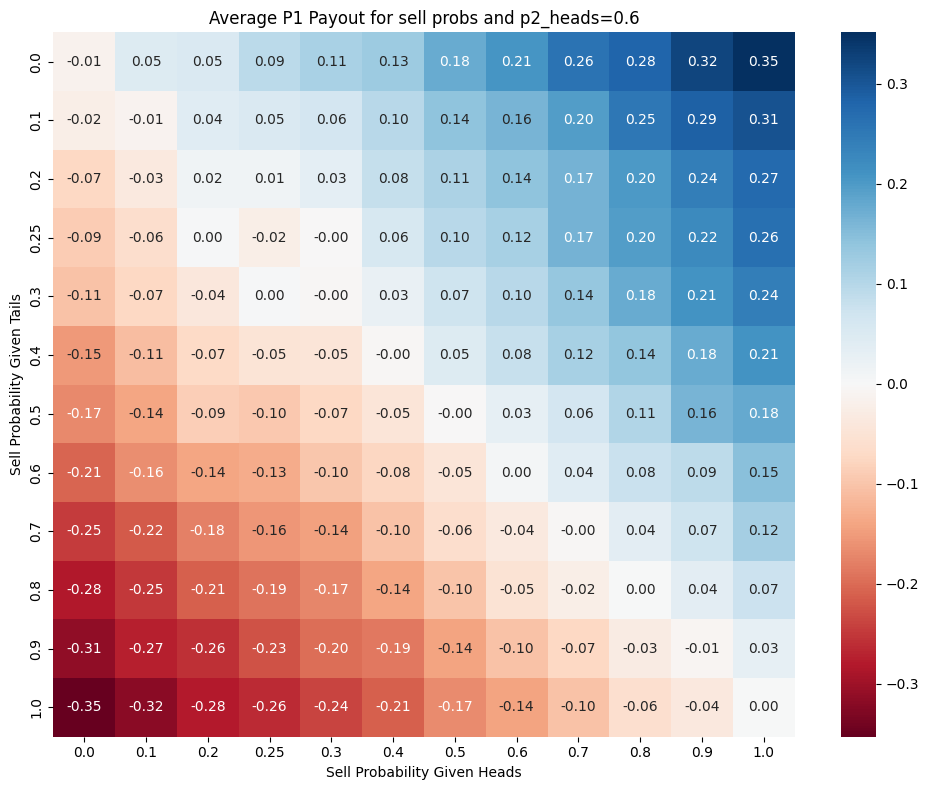

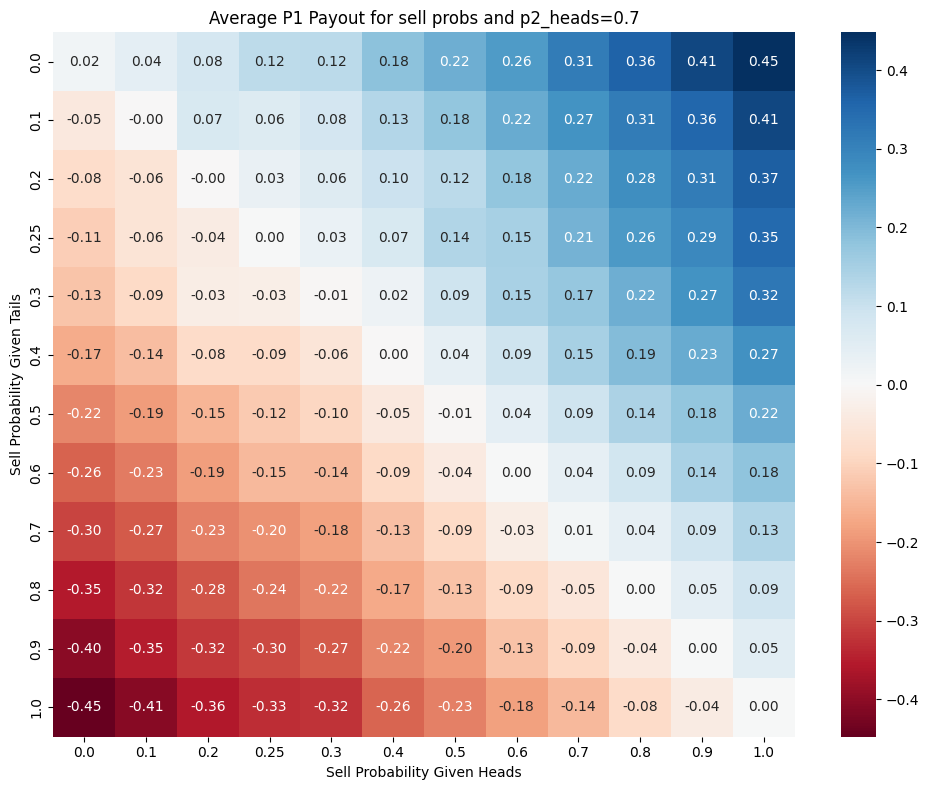

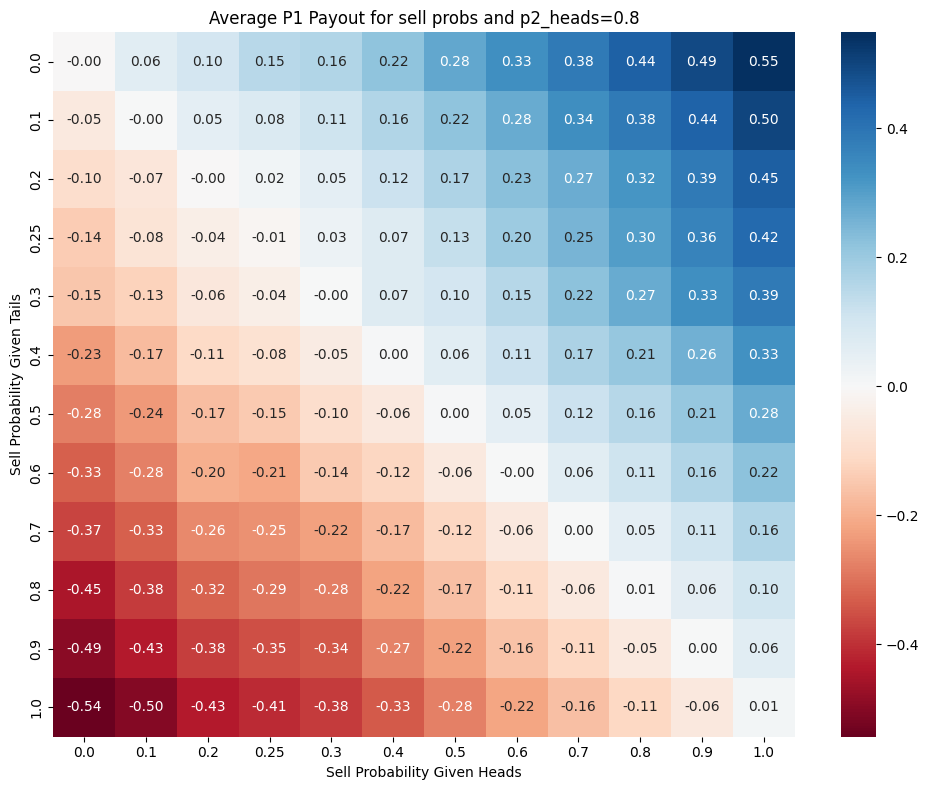

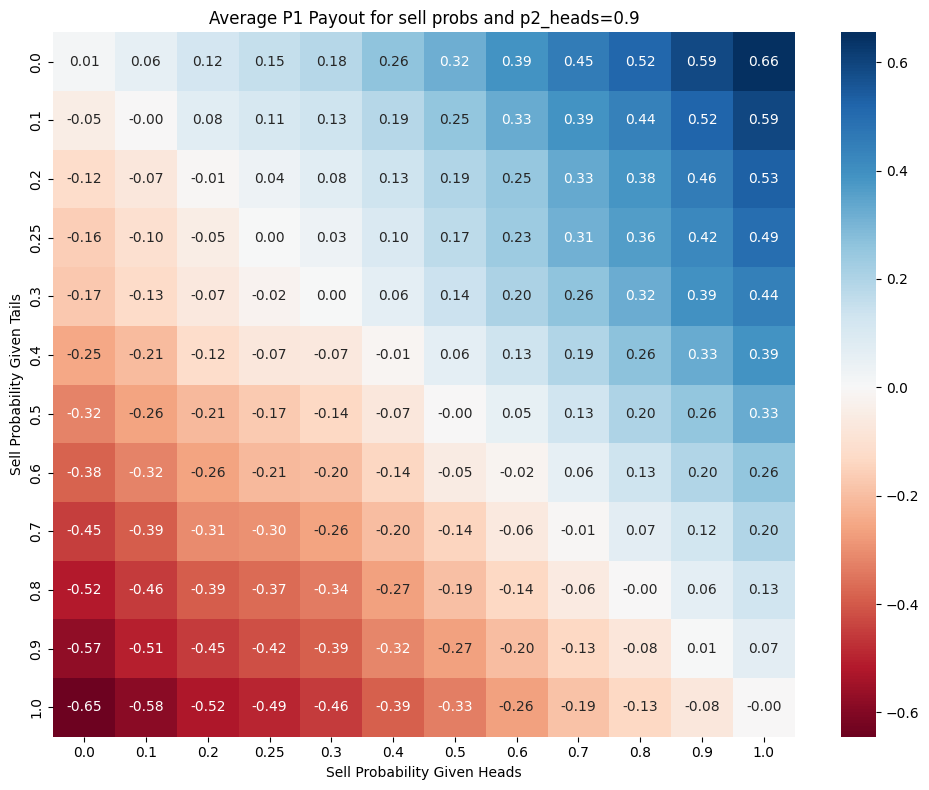

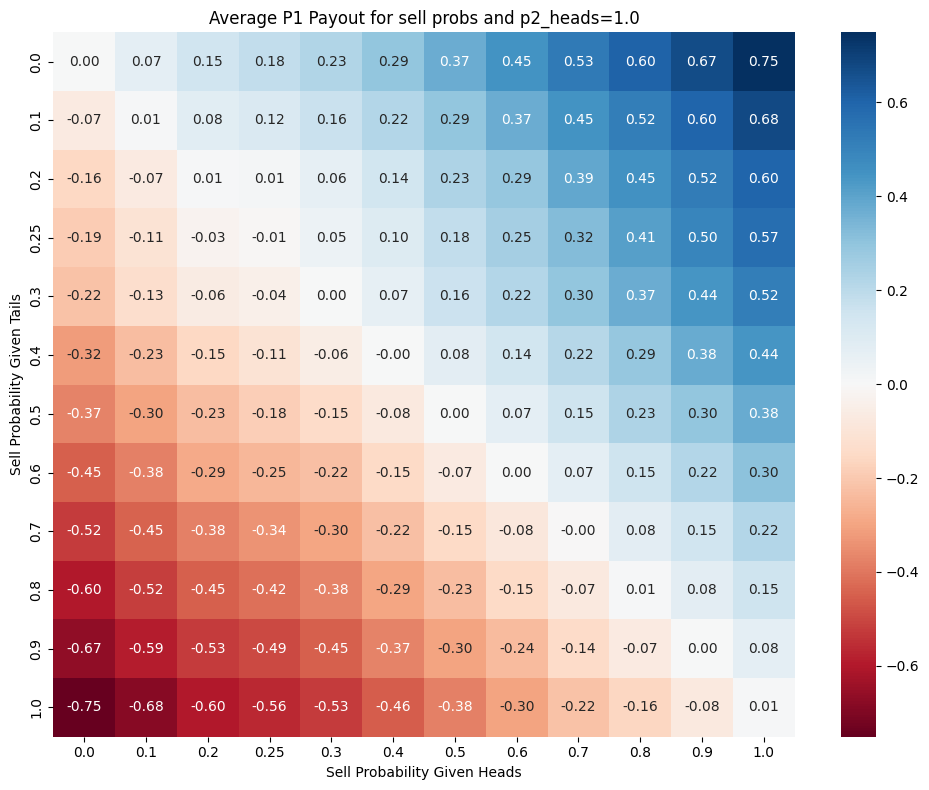

In [15]:
# Create matrices to store the values
steps = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
results = np.zeros((len(steps), len(steps)))

for _, p2_heads_prob in enumerate(steps):
    for i, sell_prob_given_heads in enumerate(steps):
        for j, sell_prob_given_tails in enumerate(steps):
            p1_payouts = [
                simulate_game(
                    p1_strategy=P1_Strategy(
                        sell_prob_given_heads=sell_prob_given_heads,
                        sell_prob_given_tails=sell_prob_given_tails,
                    ),
                    p2_strategy=P2_Strategy(
                        heads_prob=p2_heads_prob, # optimal is .25
                    ),
                )[0]
                for _ in range(10_000)
            ]
            results[j, i] = mean(p1_payouts)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results,
        xticklabels=np.round(steps, 2),
        yticklabels=np.round(steps, 2),
        cmap='RdBu',
        center=0,
        annot=True,
        fmt='.2f'
    )

    plt.xlabel('Sell Probability Given Heads')
    plt.ylabel('Sell Probability Given Tails')
    plt.title(f'Average P1 Payout for sell probs and p2_heads={p2_heads_prob:.2}')
    plt.tight_layout()
    plt.show()

# p2 search for the perfect `p=0.25`

- Let's suppose we are located at p2 decision point infoset
- Therefore, p1 has NOT chosen `sell` 
- i.e., p1 has chosen `play`
- We can induce this infoset by setting all p1's `sell` probabilities to 0


- Now, p2 may ask himself: "which p (heads_prob) minimize my exploitability?"
- I don't know, search! (but how?)
- p2 is searching for a probability dist over all of his actions


## "Naïve Monte Carlo"

Let's just simulate some rollout STARTING FROM THE CURRENT INFOSET.

For the final strategy, actions should be picked proportionally to their sampled rewards.

In [25]:
reward_p2_acc = {
    # all of his possible actions on the left
    # stats on the right
    'heads': {'sum': 0, 'n': 0},
    'tails': {'sum': 0, 'n': 0},
}

for _ in range(10_000_000):

    # pick a random action uniformly:
    p2_chosen_action = 'heads' if random.random() < 0.5 else 'tails'
    heads_prob = 1 if p2_chosen_action == 'heads' else 0

    reward_p1, _, _, p2_action = simulate_game(
        p1_strategy=P1_Strategy(
            sell_prob_given_heads=(0), # always play, so we force reaching the desired infoset
            sell_prob_given_tails=(0),
        ),
        
        p2_strategy=P2_Strategy(
            heads_prob=heads_prob, # uniform dist
        ),
    )
    
    assert p2_chosen_action == p2_action
    reward_p2_acc[p2_chosen_action]['sum'] -= reward_p1
    reward_p2_acc[p2_chosen_action]['n'] += 1
        
print(reward_p2_acc)

{'heads': {'sum': 2230, 'n': 5000382}, 'tails': {'sum': -5230, 'n': 4999618}}


In [26]:
avgs_rewards = lambda r: (r['heads']['sum']/r['heads']['n'], r['tails']['sum']/r['tails']['n'])

In [27]:
avgs_rewards(reward_p2_acc)

(0.0004459659282030853, -0.0010460799205059266)

In [28]:
_softmax(avgs_rewards(reward_p2_acc))

array([0.50037301, 0.49962699])

- We now (50%,50%) is not Nash.
- Nash, as we saw before is (25%,75%)
- A (50%,50%) strategy is explitable by p1 as shown below

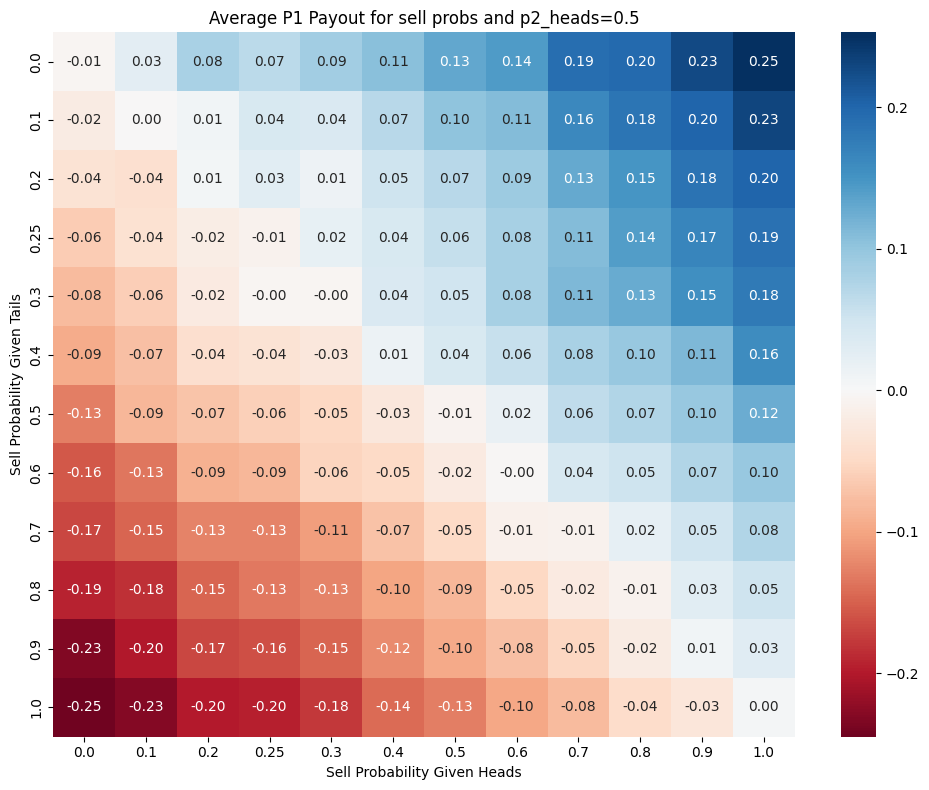

In [35]:
# Create matrices to store the values
steps = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
results = np.zeros((len(steps), len(steps)))
p2_heads_prob = 0.5

for i, sell_prob_given_heads in enumerate(steps):
    for j, sell_prob_given_tails in enumerate(steps):
        p1_payouts = [
            simulate_game(
                p1_strategy=P1_Strategy(
                    sell_prob_given_heads=sell_prob_given_heads,
                    sell_prob_given_tails=sell_prob_given_tails,
                ),
                p2_strategy=P2_Strategy(
                    heads_prob=p2_heads_prob, # optimal is .25
                ),
            )[0]
            for _ in range(10_000)
        ]
        results[j, i] = mean(p1_payouts)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    results,
    xticklabels=np.round(steps, 2),
    yticklabels=np.round(steps, 2),
    cmap='RdBu',
    center=0,
    annot=True,
    fmt='.2f'
)

plt.xlabel('Sell Probability Given Heads')
plt.ylabel('Sell Probability Given Tails')
plt.title(f'Average P1 Payout for sell probs and p2_heads={p2_heads_prob:.2}')
plt.tight_layout()
plt.show()

### Changing the outter subgames (aka, why unsafe search)

- But what if we change the reward for the outter subgames?
- E.g., changing `reward_p1_sell_on_heads` to `7`
- Does p2 explitability changes? let's see:

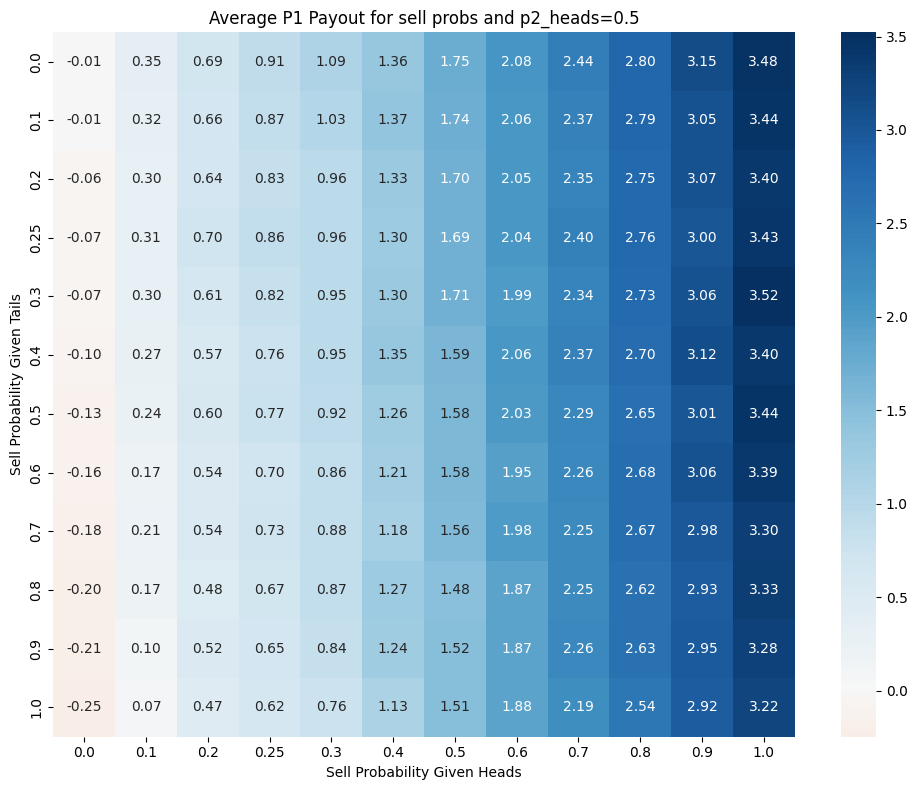

In [40]:
# Create matrices to store the values
steps = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
results = np.zeros((len(steps), len(steps)))
p2_heads_prob = 0.5

for i, sell_prob_given_heads in enumerate(steps):
    for j, sell_prob_given_tails in enumerate(steps):
        p1_payouts = [
            simulate_game(
                p1_strategy=P1_Strategy(
                    sell_prob_given_heads=sell_prob_given_heads,
                    sell_prob_given_tails=sell_prob_given_tails,
                ),
                p2_strategy=P2_Strategy(
                    heads_prob=p2_heads_prob, # optimal is .25
                ),
                reward_p1_sell_on_heads=7, # <------ CHANGING THIS!!
                reward_p1_sell_on_tails=-0.5,
            )[0]
            for _ in range(10_000)
        ]
        results[j, i] = mean(p1_payouts)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    results,
    xticklabels=np.round(steps, 2),
    yticklabels=np.round(steps, 2),
    cmap='RdBu',
    center=0,
    annot=True,
    fmt='.2f'
)

plt.xlabel('Sell Probability Given Heads')
plt.ylabel('Sell Probability Given Tails')
plt.title(f'Average P1 Payout for sell probs and p2_heads={p2_heads_prob:.2}')
plt.tight_layout()
plt.show()

Notice how changing the expected value for p1 over an outter subgame,
it changes p2 explitability.

# Statistics experiments

## Sum of random variables whose E[X]=0 does NOT converges to 0! AVG does!

- Lets flip a coin.
- If it lands heads, it rewards +1
- If it lands tails, it rewards -1
- Notice that even though the expected value is E[X] = (0.5)1 + (.5)(-1) = 0
- If we sum all the rewards, usually we don't get 0
- In fact, if we increase `n` (i.e., the sample size) the prob. of getting something different than 0 increases
- BUT THE AVERAGE OF ALL THIS REWARDS IS ZERO! NOT THE SUM (even though the reward function is simmetric and unbiased)

In [21]:
def random_walk(n):
  position = 0
  for _ in range(n):
    step = 1 if random.random() >= 0.5 else -1 # expected value is E[X] = (0.5)1 + (.5)(-1) = 0
    position += step
  return position

In [24]:
random_walk(1_000_000)

-1372

In [109]:
random_walk(10_000_000)

-696

In [110]:
random_walk(1_000_000_000)

30060

In [111]:
random_walk(10_000_000_000)

-147104

- Lesson: Si aumenta `n` también aumenta la varianza.

- Lo que nos importa es el PROMEDIO de múltiples experimentos! Eso sí

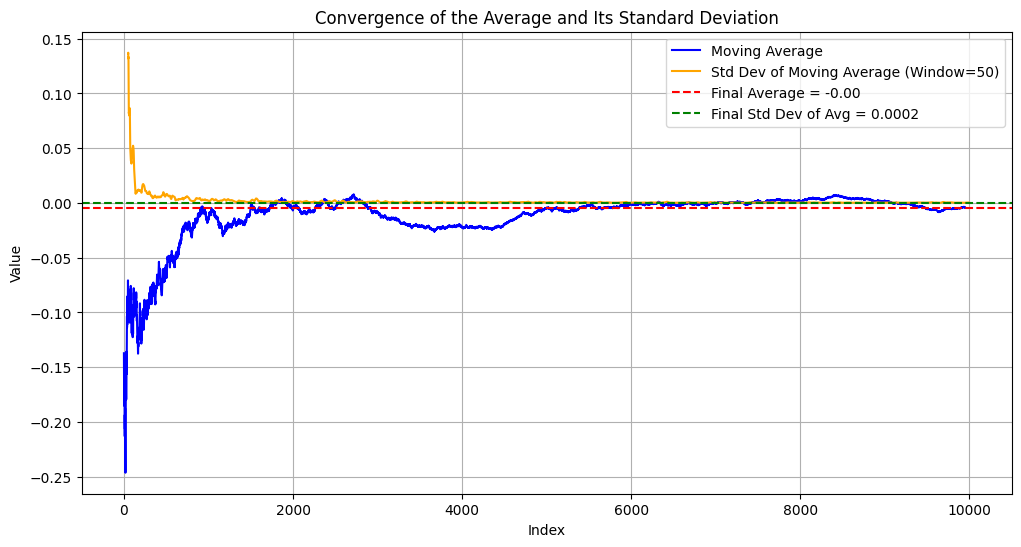

In [145]:
R = [1 if random.random() < 0.5 else -1 for _ in range(10_000)]
plot_average_convergence(R)

## EWMA: Exponentially Weighted Moving Average

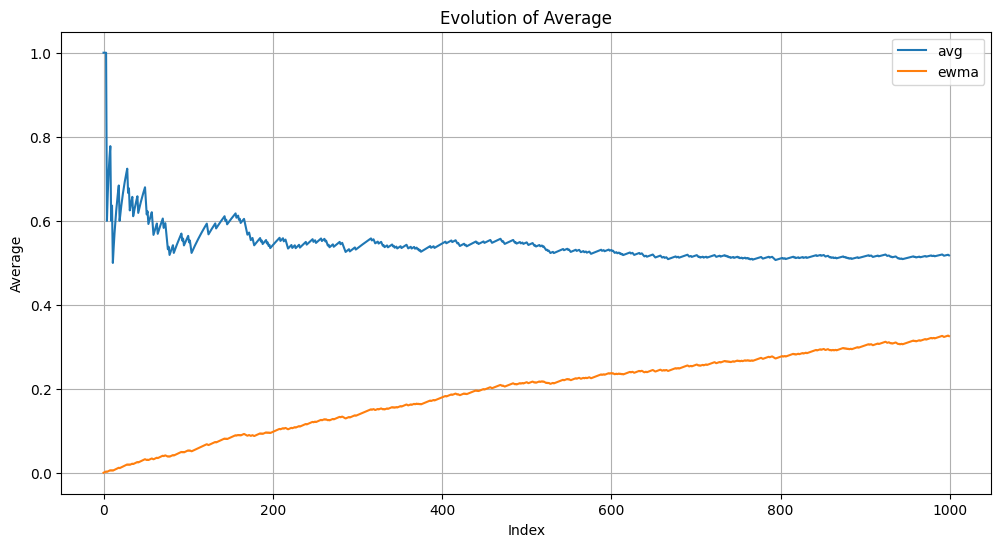

In [18]:
import statistics
rewards = []

n = 0  # Number of rewards processed
current_sum = 0  # Running sum of rewards

# exponentially weighted moving average (EWMA)
alpha = 0.001  # Smoothing factor (choose between 0 and 1)
ewma = 0  # Initial exponentially weighted moving average (starting at 0)

avg_hist = []
ewma_hist = []

for _ in range(1_000):
    reward = 1 if random.random() < 0.75 else -1
    rewards += [reward]
    n += 1  # Update the number of processed rewards
    current_sum += reward  # Update the running sum
    # Calculate the running average
    running_average = current_sum / n
    # EWMA
    ewma = (1 - alpha) * ewma + alpha * reward
    # print(f"{statistics.mean(rewards):.3f} | {running_average:.3f} | {ewma:.3f}")
    
    avg_hist += [running_average]
    ewma_hist += [ewma]


plt.figure(figsize=(12, 6))
plt.plot(avg_hist, label='avg')
plt.plot(ewma_hist, label='ewma')
plt.xlabel('Index')
plt.ylabel('Average')
plt.title('Evolution of Average')
plt.legend()
plt.grid(True)
plt.show()